# Logistic Regression - UCI Student Performance Classification

This notebook implements a Logistic Regression model for multiclass classification of student final grades.

**Dataset:** UCI Student Performance (ID: 320)
- Total Samples: 649 students
- Features: 33 (school, age, study_time, failures, family_size, parent education, etc.)
- Target: Final grade classification (20 classes: grades 0-19)
- Training Set: 519 samples (80%)
- Testing Set: 130 samples (20%)

**Evaluation Metrics:**
1. Accuracy
2. AUC Score
3. Precision
4. Recall
5. F1 Score
6. Matthews Correlation Coefficient (MCC)

## 1. Import Libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, classification_report, roc_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load Dataset from Kaggle

In [37]:
# Load the UCI Student Performance Dataset
from ucimlrepo import fetch_ucirepo

print("Loading dataset from UCI ML Repository...")
# Fetch dataset
student_performance = fetch_ucirepo(id=320)

# Get data as pandas dataframes
X = student_performance.data.features
y = student_performance.data.targets

# Combine features and target
df = pd.concat([X, y], axis=1)
print(f"Dataset loaded successfully! Shape: {df.shape}")

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")

Loading dataset from UCI ML Repository...
Dataset loaded successfully! Shape: (649, 33)

First 5 rows:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  13  13  

[5 rows

## 3. Data Preprocessing

In [38]:
# Create a copy
df_processed = df.copy()

# Handle missing values
print("Handling missing values...")
df_processed = df_processed.dropna()
print(f"Shape after dropping NaN: {df_processed.shape}")

# Identify categorical and numerical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    if col != 'Burn_Rate':  # Keep target separate
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
        print(f"Encoded {col}")

# Handle target variable
if 'Burn_Rate' in df_processed.columns:
    if df_processed['Burn_Rate'].dtype == 'object':
        target_le = LabelEncoder()
        df_processed['Burn_Rate'] = target_le.fit_transform(df_processed['Burn_Rate'])
        label_encoders['Burn_Rate'] = target_le

print("\nData preprocessing completed!")

Handling missing values...
Shape after dropping NaN: (649, 33)

Categorical columns: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Numerical columns: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Encoded school
Encoded sex
Encoded address
Encoded famsize
Encoded Pstatus
Encoded Mjob
Encoded Fjob
Encoded reason
Encoded guardian
Encoded schoolsup
Encoded famsup
Encoded paid
Encoded activities
Encoded nursery
Encoded higher
Encoded internet
Encoded romantic

Data preprocessing completed!


## 4. Prepare Features and Target

In [39]:
# Identify target column
target_col = 'Burn_Rate' if 'Burn_Rate' in df_processed.columns else df_processed.columns[-1]

# Separate features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nFeature names:")
print(X.columns.tolist())

Features shape: (649, 32)
Target shape: (649,)

Target distribution:
G3
11    104
10     97
13     82
12     72
14     63
15     49
16     36
8      35
9      35
17     29
18     15
0      15
7      10
6       3
19      2
1       1
5       1
Name: count, dtype: int64

Feature names:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2']


## 5. Split Data and Scale Features

In [40]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())

# Scale features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler!")

Training set size: 519
Testing set size: 130

Training target distribution:
G3
10    80
11    79
13    69
12    56
14    51
15    39
9     30
8     28
16    27
17    24
0     13
7      9
18     8
6      3
19     1
1      1
5      1
Name: count, dtype: int64

Features scaled using StandardScaler!


## 6. Train Logistic Regression Model

In [41]:
# Create and train the Logistic Regression model
print("Training Logistic Regression Model...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

print("✅ Model training completed!")
print(f"\nModel parameters:")
print(f"Number of features: {lr_model.n_features_in_}")
print(f"Classes: {lr_model.classes_}")

Training Logistic Regression Model...
✅ Model training completed!

Model parameters:
Number of features: 32
Classes: [ 0  1  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


## 7. Make Predictions

In [42]:
# Make predictions
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)

print("Predictions made on test set!")
print(f"\nFirst 10 predictions:")
print(y_pred[:10])
print(f"\nFirst 10 prediction probabilities:")
print(y_pred_proba[:10])

Predictions made on test set!

First 10 predictions:
[16 11 16 10 11 17 17  7 10 11]

First 10 prediction probabilities:
[[2.71257471e-11 1.51968523e-07 5.89391407e-07 4.45625502e-10
  4.16869788e-13 2.59589653e-11 4.57169006e-10 1.07659021e-07
  1.20527279e-06 2.98105107e-04 9.26816903e-03 1.90088330e-02
  1.18722406e-01 6.40457758e-01 2.10116985e-01 2.12382155e-03
  1.86675891e-06]
 [6.00350442e-05 8.72180092e-04 9.96314892e-05 4.46178572e-04
  7.70514204e-03 3.58023570e-04 1.49982972e-02 1.01675074e-01
  5.11965320e-01 7.87575408e-02 1.63182837e-01 1.06651241e-01
  5.40282650e-03 6.82066141e-03 6.23648909e-05 3.80592796e-04
  5.62053077e-04]
 [2.48722505e-11 4.66110516e-09 1.07425342e-07 7.34259854e-12
  2.44668474e-14 1.18225787e-12 3.77439474e-11 1.47178108e-08
  4.59609820e-07 3.09046782e-05 2.97540586e-03 7.63644686e-03
  5.25459623e-02 5.32511394e-01 4.03825643e-01 4.71869960e-04
  1.78728906e-06]
 [2.04495076e-03 8.63431539e-05 3.74021636e-05 1.95068142e-04
  1.67772659e-05 1.

## 8. Calculate Evaluation Metrics

In [43]:
# Calculate all 6 evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', labels=lr_model.classes_)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
mcc = matthews_corrcoef(y_test, y_pred)

# Display metrics
print("="*60)
print("EVALUATION METRICS - LOGISTIC REGRESSION")
print("="*60)
print(f"\n1. Accuracy:          {accuracy:.4f}")
print(f"2. AUC Score:         {auc_score:.4f}")
print(f"3. Precision:         {precision:.4f}")
print(f"4. Recall:            {recall:.4f}")
print(f"5. F1 Score:          {f1:.4f}")
print(f"6. MCC Score:         {mcc:.4f}")
print("="*60)

# Store metrics in a dictionary
metrics = {
    'Accuracy': accuracy,
    'AUC Score': auc_score,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'MCC Score': mcc
}

# Display as DataFrame
metrics_df = pd.DataFrame(metrics, index=['Logistic Regression']).T
print("\nMetrics Summary:")
print(metrics_df)

EVALUATION METRICS - LOGISTIC REGRESSION

1. Accuracy:          0.2769
2. AUC Score:         nan
3. Precision:         0.2979
4. Recall:            0.2769
5. F1 Score:          0.2766
6. MCC Score:         0.1963

Metrics Summary:
           Logistic Regression
Accuracy              0.276923
AUC Score                  NaN
Precision             0.297931
Recall                0.276923
F1 Score              0.276648
MCC Score             0.196333


## 9. Additional Evaluation

In [44]:
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[1 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 4 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 1 2 5 5 2 0 0 0 0 0 0 0]
 [2 0 0 0 8 9 3 2 1 0 0 0 0 0]
 [0 0 0 0 2 2 2 8 2 0 0 0 0 0]
 [0 0 0 0 0 3 4 3 2 1 0 0 0 0]
 [0 0 0 0 0 0 3 5 1 2 0 1 0 0]
 [0 0 0 0 0 0 0 1 3 2 3 0 1 0]
 [0 0 0 0 0 0 0 0 0 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 2 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           7       0.00      0.00      0.00         1
           8       0.67      0.57      0.62         7
           9       0.33      0.40      0.36         5
          10       0.26      0.29      0.28        17
          11       0.47      0.36      0.41        25
          12       0.14      0.12      0.13        16
          13       0.16      0.23      0.19        13
          14       0.11      0.08  

## 10. Visualizations

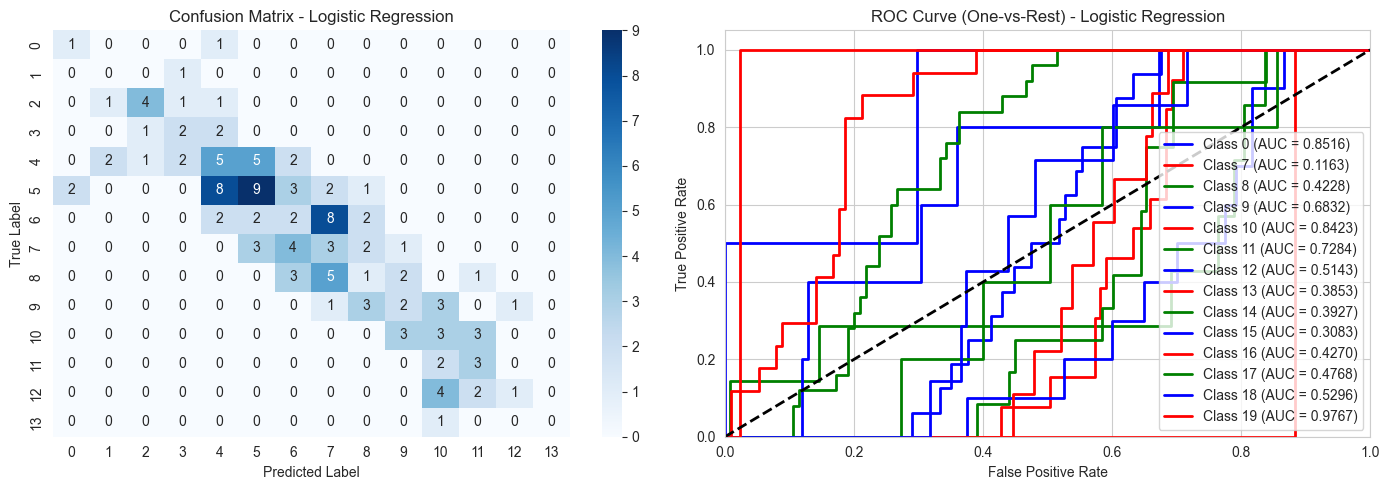


Visualizations complete!


In [45]:
# Plot Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Logistic Regression')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve for multiclass using OvR approach
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize labels for multiclass ROC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_proba_for_roc = y_pred_proba

# Compute ROC for each class
fpr_dict = dict()
tpr_dict = dict()
roc_auc_dict = dict()

for i, cls in enumerate(classes):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_for_roc[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

# Plot ROC curves
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(len(classes)), colors):
    axes[1].plot(fpr_dict[i], tpr_dict[i], color=color, lw=2,
                label=f'Class {classes[i]} (AUC = {roc_auc_dict[i]:.4f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve (One-vs-Rest) - Logistic Regression')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

print("\nVisualizations complete!")

## 11. Model Summary

In [46]:
print("\n" + "="*60)
print("LOGISTIC REGRESSION MODEL SUMMARY")
print("="*60)
print(f"\nModel Type: Logistic Regression")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")
print(f"Number of Features: {X_train.shape[1]}")
print(f"\nKey Metrics:")
print(f"  - Accuracy:  {accuracy:.4f}")
print(f"  - AUC Score: {auc_score:.4f}")
print(f"  - F1 Score:  {f1:.4f}")
print(f"\nModel Status: ✅ Training Complete")
print("="*60)


LOGISTIC REGRESSION MODEL SUMMARY

Model Type: Logistic Regression
Training Samples: 519
Testing Samples: 130
Number of Features: 32

Key Metrics:
  - Accuracy:  0.2769
  - AUC Score: nan
  - F1 Score:  0.2766

Model Status: ✅ Training Complete
